In [13]:
import os
testPath = '/mnt/ibrixfs01-MRI/analysis/washen/temp/test/'
testFiles = os.listdir(testPath)


In [98]:
weightPath = '/mnt/ibrixfs01-MRI/analysis/washen/temp/weights/121118/'
weights = os.listdir(weightPath)
nWeights = len(weights)

In [6]:
from __future__ import print_function

import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from keras.models import Model
from keras.layers import Input, concatenate, Conv1D, MaxPooling1D, Conv2DTranspose,Lambda
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import tensorflow as tf
import keras
import cv2
import sys

K.set_image_data_format('channels_last')  # TF dimension ordering in this code
os.environ["CUDA_VISIBLE_DEVICES"]="2"

size= 256
batch_size=16

import unet
model = unet.get_unet()

Using TensorFlow backend.


In [7]:
def dice_coef(y_true, y_pred):
    intersection = np.sum(np.multiply(y_true,y_pred))
    
    print(('%d\t%d\t%d\t')%(intersection,np.sum(y_true),np.sum(y_pred)))

    return (2. * intersection ) / (np.sum(y_true) + np.sum(y_pred))

In [60]:
f = open(testPath+'mean_sd.txt', 'w')

for filename in testFiles:
    if ('-T1' in filename):
        print(filename)
        patID = str.split(filename,'-T1')[0]
        
        v_t1 = np.load(testPath+filename)
        v_t2 = np.load(testPath+filename.replace('-T1','-T2'))
        bw = np.load(testPath+filename.replace('-T1','-BW'))
        
        m1 = np.mean(v_t1)
        m2 = np.mean(v_t2)
        sd1 = np.std(v_t1)
        sd2 = np.std(v_t2)
        
        shape = bw.shape
        predVolume = np.zeros(shape)
        for w in range(nWeights):
            model.load_weights(weightPath+weights[w])
            
            for sl in range(shape[2]):      
                x = np.zeros((1,size,size,2)) 
                x[0,:,:,0] = (v_t1[:,:,sl]-m1)/sd1
                x[0,:,:,1] = (v_t2[:,:,sl]-m2)/sd2 
                
                pred = model.predict(x)
                predVolume[:,:,sl] += pred[0,:,:,0]

        predVolume = predVolume/nWeights
        bw_pred = 1*(predVolume>0.33)
        print(dice_coef(1*(bw>0),bw_pred))

LGG-659-T1.npy
672	1757	675	
0.5526315789473685
LGG-547-T1.npy
3334	6831	5992	
0.5200031193948375
LGG-639-T1.npy
0	1893	0	
0.0
LGG-590-T1.npy
0	1275	0	
0.0
LGG-351-T1.npy
2051	5223	5719	
0.37488576128678486
LGG-263-T1.npy
3391	4223	8193	
0.5462306701030928
LGG-305-T1.npy
10798	12182	28794	
0.5270402186645842
LGG-261-T1.npy
3523	6425	14448	
0.3375652757150386
LGG-515-T1.npy


ValueError: could not broadcast input array from shape (512,512) into shape (256,256)

In [105]:
f = open(testPath+'mean_sd.txt', 'w')

for filename in testFiles[33:34]:
    if ('-T1' in filename):
        print(filename)
        patID = str.split(filename,'-T1')[0]
        
        v_t1 = np.load(testPath+filename)
        v_t2 = np.load(testPath+filename.replace('-T1','-T2'))
        bw = np.load(testPath+filename.replace('-T1','-BW'))
        
        m1 = np.mean(v_t1)
        m2 = np.mean(v_t2)
        sd1 = np.std(v_t1)
        sd2 = np.std(v_t2)
        
        shape = bw.shape
        predVolume = np.zeros(shape)
        for w in range(nWeights):
            model.load_weights(weightPath+weights[w])
            
            for sl in range(shape[2]):      
                x = np.zeros((1,size,size,2)) 
                x[0,:,:,0] = (v_t1[:,:,sl]-m1)/sd1
                x[0,:,:,1] = (v_t2[:,:,sl]-m2)/sd2 
                
                pred = model.predict(x)
                predVolume[:,:,sl] += pred[0,:,:,0]

        predVolume = predVolume/nWeights
        bw_pred = 1*(predVolume>0.33)
        print(dice_coef(1*(bw>0),bw_pred))

LGG-616-T1.npy
3075	3527	8441	
0.513870320855615


In [106]:
for i in range(bw.shape[2]):
    if (np.sum(bw[:,:,i])>0):
        print(i)
print(" ")
for i in range(bw_pred.shape[2]):
    if (np.sum(bw_pred[:,:,i])>0):
        print(i)

41
42
43
 
36
38
39
40
41
42
43
44
45
46
47


In [101]:
from matplotlib import pyplot as plt
%matplotlib inline

In [107]:
sl = 42
masked_pred = np.ma.masked_where(bw_pred[:,:,sl]==0, bw_pred[:,:,sl])
masked_true = np.ma.masked_where(bw[:,:,sl]==0, bw[:,:,sl])

In [108]:
v_t1 = np.load(testPath+filename)
v_t2 = np.load(testPath+filename.replace('T1','T2'))

1016	1178	1060	


(-0.5, 255.5, 255.5, -0.5)

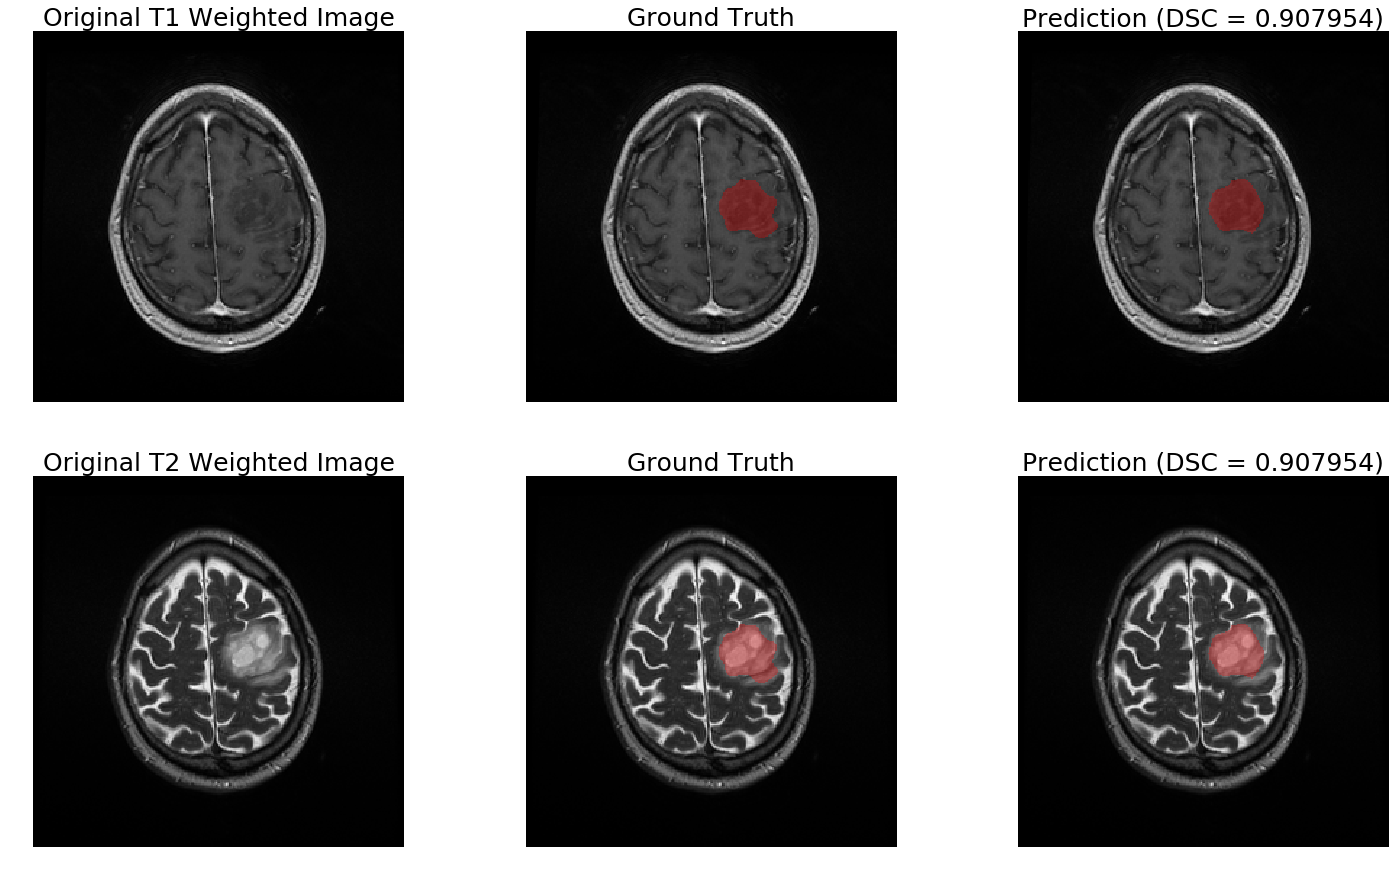

In [109]:
dsc = dice_coef(1*(bw[:,:,sl]>0),1*(bw_pred[:,:,sl]>0))

f = plt.figure(figsize=(25,15))
plt.set_cmap('gray')

ax = f.add_subplot(2,3,1)
ax.imshow(v_t1[:,:,sl].T)
ax.set_title('Original T1 Weighted Image',fontsize = 25)
ax.axis('off')

ax = f.add_subplot(2,3,2)
ax.imshow(v_t1[:,:,sl].T, 'gray', interpolation='none')
ax.imshow(masked_true.T, 'hsv', interpolation='none', alpha=0.3)
ax.set_title('Ground Truth',fontsize = 25)
ax.axis('off')

ax = f.add_subplot(2,3,3)
ax.imshow(v_t1[:,:,sl].T, 'gray', interpolation='none')
ax.imshow(masked_pred.T, 'hsv', interpolation='none', alpha=0.3)
ax.set_title(('Prediction (DSC = %02f)')%dsc,fontsize = 25)
ax.axis('off')

ax = f.add_subplot(2,3,4)
ax.imshow(v_t2[:,:,sl].T)
ax.set_title('Original T2 Weighted Image',fontsize = 25)
ax.axis('off')

ax = f.add_subplot(2,3,5)
ax.imshow(v_t2[:,:,sl].T, 'gray', interpolation='none')
ax.imshow(masked_true.T, 'hsv', interpolation='none', alpha=0.3)
ax.set_title('Ground Truth',fontsize = 25)
ax.axis('off')

ax = f.add_subplot(2,3,6)
ax.imshow(v_t2[:,:,sl].T, 'gray', interpolation='none')
ax.imshow(masked_pred.T, 'hsv', interpolation='none', alpha=0.3)
ax.set_title(('Prediction (DSC = %02f)')%dsc,fontsize = 25)
ax.axis('off')




In [114]:
v_t1[:,:,40]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.91610718, -2.06364441, -1.76939392, ...,  0.        ,
         0.        ,  0.        ],
       [19.40100098, 21.46852112, 17.33888245, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.55933279, -0.5089286 , -0.59498674, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

(-0.5, 255.5, 255.5, -0.5)

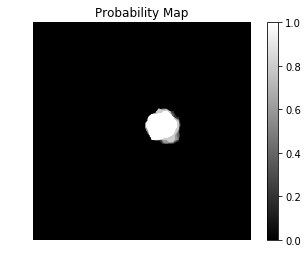

In [79]:
plt.imshow(predVolume[:,:,sl].T)
plt.colorbar()
plt.title('Probability Map')
plt.axis('off')

In [68]:
predVolume[100,105,40]

0.3999979257583618

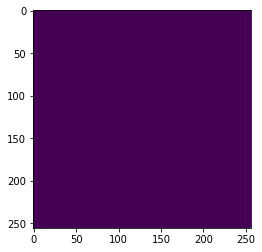

In [78]:
plt.imshow(predVolume[:,:,41])

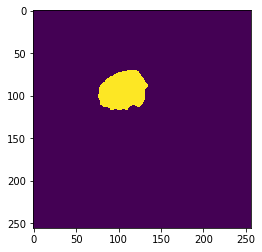

In [59]:
plt.imshow(bw[:,:,40])

In [43]:
test = pred[0,:,:,0]

In [44]:
test.shape

(256, 256)